## Libraries

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as pdd
import math
import seaborn as sns
import datetime as dt
from datetime import datetime
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt

## Load Data

In [15]:
abtzdt = pdd.DataReader('ABTZY', data_source='yahoo', start='2020-01-01', end = '2022-10-18')
abtzdt

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-12-31,11.06,11.06,11.06,11.06,0.0,10.25704
2020-01-02,11.06,11.06,11.06,11.06,0.0,10.25704
2020-01-03,11.06,11.06,11.06,11.06,0.0,10.25704
2020-01-06,11.06,11.06,11.06,11.06,0.0,10.25704
2020-01-07,11.06,11.06,11.06,11.06,0.0,10.25704
...,...,...,...,...,...,...
2022-10-11,9.73,9.73,9.73,9.73,0.0,9.73000
2022-10-12,9.73,9.73,9.73,9.73,0.0,9.73000
2022-10-13,9.73,9.73,9.73,9.73,0.0,9.73000


##  Processing Data

<AxesSubplot:xlabel='Date'>

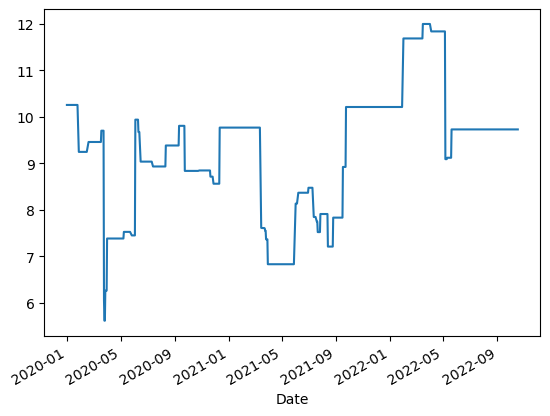

In [16]:
yAdjC = abtzdt['Adj Close'] # Visualization graph for year 2020 to 2022
yAdjC.index=abtzdt.index
yAdjC.plot()

In [4]:
abtzdt.reset_index(drop=True, inplace=True)
abtzdt.fillna(abtzdt.mean(), inplace=True)
abtzdt.head()

,High,Low,Open,Close,Volume,Adj Close
0,11.06,11.06,11.06,11.06,0.0,10.25704
1,11.06,11.06,11.06,11.06,0.0,10.25704
2,11.06,11.06,11.06,11.06,0.0,10.25704
3,11.06,11.06,11.06,11.06,0.0,10.25704
4,11.06,11.06,11.06,11.06,0.0,10.25704


In [5]:
from sklearn.model_selection import train_test_split

x = []
y = []

window_size = 100
for i in range(1, len(abtzdt) - window_size - 1, 1):
    first = abtzdt.iloc[i, 2]
    temp = []
    temp2 = []
    for j in range(window_size):
        temp.append((abtzdt.iloc[i + j, 2] - first / first))
    temp2.append((abtzdt.iloc[i + window_size, 2] - first / first))
    x.append(np.array(temp).reshape(100,1))
    y.append(np.array(temp2).reshape(1,1))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                    shuffle=True)

train_x = np.array(x_train)
test_x = np.array(x_test)
train_y = np.array(y_train)
test_y = np.array(y_test)

train_x = train_x.reshape(train_x.shape[0],100,1)
test_x = test_x.reshape(test_x.shape[0],100,1)
train_y = train_y.reshape(train_y.shape[0])
test_y = test_y.reshape(test_y.shape[0])

## Choosing Model

In [6]:
# Model Choose is One Dimension CNN and Bidirectional GRU
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, GRU, Dense, Dropout, Bidirectional, TimeDistributed
from tensorflow.keras.layers import MaxPooling1D, Flatten
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import RootMeanSquaredError

model = tf.keras.Sequential()

model.add(Conv1D(64,kernel_size=3, activation='relu', input_shape=(100,1)))
model.add(Conv1D(128,kernel_size=3, activation='relu'))
model.add(Conv1D(64,kernel_size=3, activation='relu'))
model.add(MaxPooling1D(2))

# GRU layers
model.add(Bidirectional(GRU(100, return_sequences=False)))
model.add(Dropout(0.5))

#Final layers
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse', metrics=['mse','mae'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 98, 64)            256       
                                                                 
 conv1d_1 (Conv1D)           (None, 96, 128)           24704     
                                                                 
 conv1d_2 (Conv1D)           (None, 94, 64)            24640     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 47, 64)           0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 200)              99600     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 200)               0

## Training

In [7]:
batch_size = 200
buffer_size = 10000

In [8]:
# predictTrain combination of train(x,y) 
# predictTest combination of test (x,y)
# also it has the batch size & buffer size
predictTrain = tf.data.Dataset.from_tensor_slices((train_x, train_y))
predictTrain = predictTrain.cache().shuffle(buffer_size).batch(batch_size).repeat()

predictTest = tf.data.Dataset.from_tensor_slices((test_x, test_y))
predictTest = predictTest.batch(batch_size).repeat()

history = model.fit(predictTrain, epochs = 20, steps_per_epoch=200, 
                    validation_data=predictTest, validation_steps=50)

Epoch 1/20
200/200 [==============================] - 34s 108ms/step - loss: 3.4369 - mse: 3.4369 - mae: 1.2896 - val_loss: 0.3007 - val_mse: 0.3007 - val_mae: 0.3896
Epoch 2/20
200/200 [==============================] - 18s 89ms/step - loss: 0.8773 - mse: 0.8773 - mae: 0.7338 - val_loss: 0.1499 - val_mse: 0.1499 - val_mae: 0.2036
Epoch 3/20
200/200 [==============================] - 16s 78ms/step - loss: 0.7192 - mse: 0.7192 - mae: 0.6646 - val_loss: 0.1834 - val_mse: 0.1834 - val_mae: 0.3150
Epoch 4/20
200/200 [==============================] - 18s 89ms/step - loss: 0.6224 - mse: 0.6224 - mae: 0.6150 - val_loss: 0.1156 - val_mse: 0.1156 - val_mae: 0.1627
Epoch 5/20
200/200 [==============================] - 16s 78ms/step - loss: 0.6025 - mse: 0.6025 - mae: 0.6061 - val_loss: 0.1043 - val_mse: 0.1043 - val_mae: 0.1550
Epoch 6/20
200/200 [==============================] - 17s 88ms/step - loss: 0.5673 - mse: 0.5673 - mae: 0.5850 - val_loss: 0.1299 - val_mse: 0.1299 - val_mae: 0.2470
Epo

## Evaluation

In [9]:
model.evaluate(test_x,test_y)
# Mean Squared Error (MSE) of 2.91%
# Mean Absolute Error (MAE) of 11.12%
# Loss of 2.91%

4/4 [==============================] - 3s 68ms/step - loss: 0.0729 - mse: 0.0729 - mae: 0.1691


[0.07290339469909668, 0.07290339469909668, 0.1690990924835205]

In [10]:
hist = pd.DataFrame(history.history)
hist.head() # here is the 5 rows of training result 

,loss,mse,mae,val_loss,val_mse,val_mae
0,3.436875,3.436875,1.289620,0.300706,0.300706,0.389646
1,0.877318,0.877318,0.733793,0.149917,0.149917,0.203597
2,0.719194,0.719194,0.664590,0.183446,0.183446,0.315021
3,0.622351,0.622351,0.614953,0.115593,0.115593,0.162710
4,0.602487,0.602487,0.606066,0.104334,0.104334,0.155025


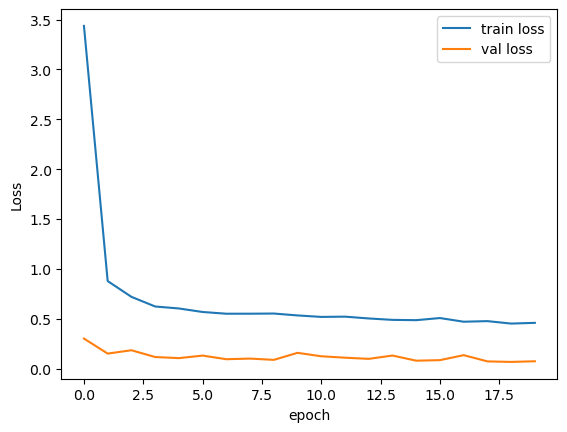

In [11]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
# Graph of train loss and validation loss

## Prediction

In [12]:
# Predict stock values after model is trained. 
# We keep the predicted values and target values for visual presentation.
# Run predictTrain or predictTest to check the preformance.
predicted_value = []
y_orig = []
count =0;
for x, y in predictTrain.take(20):
    y_orig.append(y[0].numpy())
    t_pred= model.predict(x)
    predicted_value.append(t_pred[0])

7/7 [==============================] - 0s 11ms/step


<AxesSubplot:>

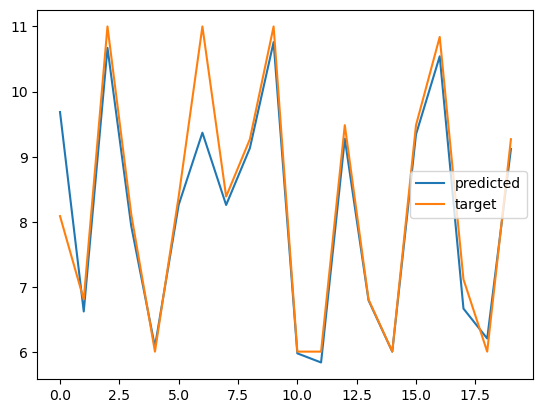

In [13]:
# Plot the predicted value and the target values together.
y_pred = [predicted_value[i][0] for i in range(len(predicted_value))]
result = pd.DataFrame({'predicted':y_pred, 'target':y_orig})
result.plot()